In [1]:
%pip install ccrvam

Note: you may need to restart the kernel to use updated packages.


> Make sure to have ccrvam's latest version installed using `pip`. More information about the latest version can be found at https://pypi.org/project/ccrvam/

In [2]:
import numpy as np
from ccrvam import (
    bootstrap_ccram,
    permutation_test_ccram,
    bootstrap_predict_ccr_summary
)
from ccrvam import DataProcessor

# 2-Dimensional Case 

### Create Sample Contingency Table

For a 2D contingency table:

- `axis=0`: First variable ($X_1$) with 5 categories
- `axis=1`: Second variable ($X_2$) with 3 categories

The axis indexing follows NumPy's convention, starting from the outermost dimension. The variables are ordered such that:

- $X_1$ corresponds to (rows)
- $X_2$ corresponds to (columns)

This ordering is important for calculating measures of regression association between two variables.

In [3]:
contingency_table = np.array([
    [0, 0, 20],
    [0, 10, 0],
    [20, 0, 0],
    [0, 10, 0],
    [0, 0, 20]
])

### Bootstrap Confidence Interval for CCRAM and SCCRAM

Below, we utilize the bootstrap approach to estimate the variability/uncertainty associated with the estimated CCRAM and SCCRAM.

Before using the bootstrap analysis functions, it's helpful to understand what each input argument does:

- `contingency_table`: Your multi-dimensional array of counts
- `predictors`: Indices of predictors (1-indexed, can be single value or list)
- `response`: Index of the response variable (1-indexed)
- `scaled`: Whether to use standard CCRAM (False) or scaled SCCRAM (True)
- `n_resamples`: Number of bootstrap samples (default is 9999)
- `confidence_level`: Confidence level for interval (default is 0.95 = 95% CI)
- `method`: How to calculate confidence intervals ("percentile", "basic", or "BCa")
- `random_state`: For reproducible results, set a seed value (default is None)

The function returns the observed (S)CCRAM value, confidence intervals, bootstrap estimates of (S)CCRAM as a list of length `n_resamples`, and visualization capabilities.

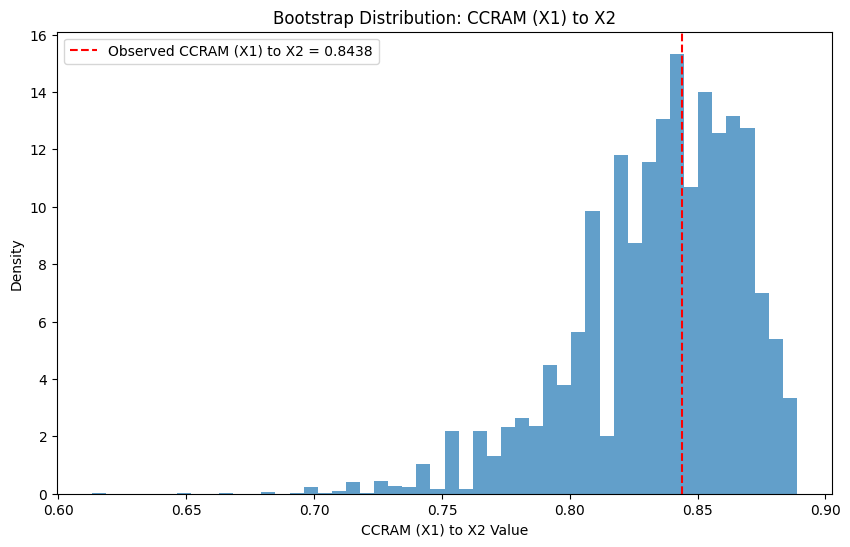

In [4]:
ccram_result = bootstrap_ccram(
    contingency_table,
    predictors=[1],
    response=2,
    n_resamples=9999,
    scaled=False,
    confidence_level=0.95,
    method="percentile",
    random_state=None
)

In [5]:
print(f"Metric Name: {ccram_result.metric_name}")
print(f"Observed Value: {ccram_result.observed_value:.4f}")
print(f"95% CI: ({ccram_result.confidence_interval[0]:.4f}, {ccram_result.confidence_interval[1]:.4f})")
print(f"Standard Error: {ccram_result.standard_error:.4f}")
print(f"Bootstrap Estimates: {type(ccram_result.bootstrap_distribution)}")

# Retrieve bootstrap estimates
bootstrap_estimates = ccram_result.bootstrap_distribution

# Calculate bootstrap bias
bootstrap_mean = np.mean(bootstrap_estimates)
bootstrap_bias = bootstrap_mean - ccram_result.observed_value

# Calculate bootstrap standard error
bootstrap_std_error = np.std(bootstrap_estimates, ddof=1)

# Calculate ratio of bias to standard error
bias_to_se_ratio = bootstrap_bias / bootstrap_std_error

print("\nAdditional Bootstrap Statistics:")
print(f"Bootstrap Mean: {bootstrap_mean:.4f}")
print(f"Bootstrap Bias: {bootstrap_bias:.4f}")
print(f"Bootstrap Standard Error: {bootstrap_std_error:.4f}")
print(f"Bias to Standard Error Ratio: {bias_to_se_ratio:.4f}")

Metric Name: CCRAM (X1) to X2
Observed Value: 0.8438
95% CI: (0.7553, 0.8817)
Standard Error: 0.0325
Bootstrap Estimates: <class 'numpy.ndarray'>

Additional Bootstrap Statistics:
Bootstrap Mean: 0.8353
Bootstrap Bias: -0.0085
Bootstrap Standard Error: 0.0325
Bias to Standard Error Ratio: -0.2612


One can extract the histogram plot of the bootstrap distribution from the result object as follows:

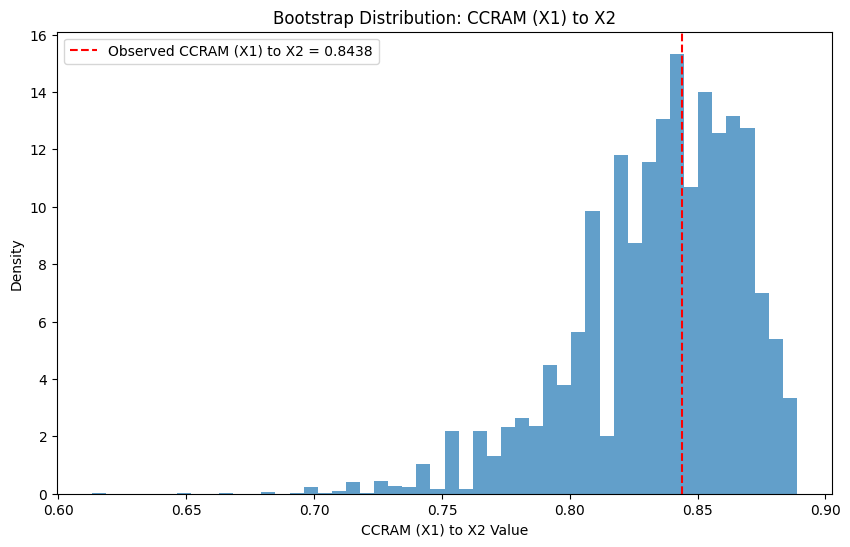

In [6]:
# Plot histogram of bootstrap estimates
ccram_result.histogram_fig

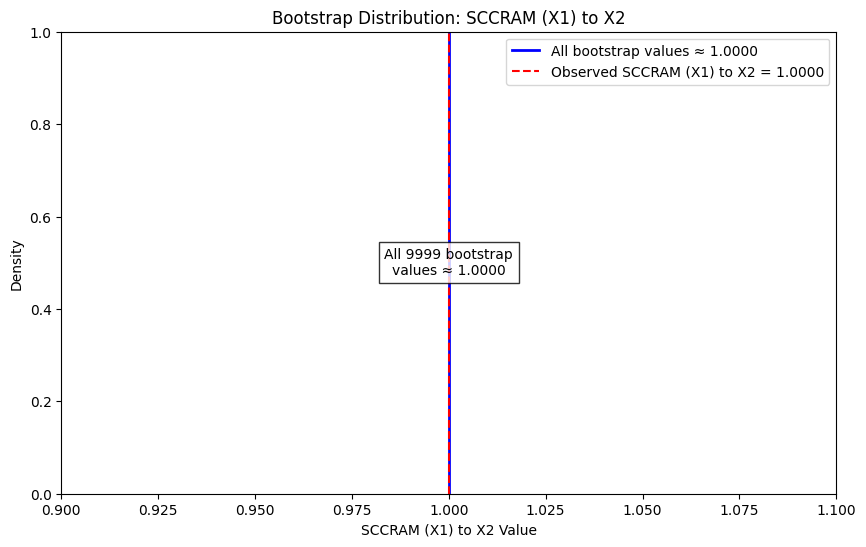

In [7]:
sccram_result = bootstrap_ccram(
    contingency_table,
    predictors=[1],
    response=2,
    scaled=True,
    confidence_level=0.95,
    method="percentile",
    n_resamples=9999
)

In [8]:

print(f"Metric Name: {sccram_result.metric_name}")
print(f"Observed Value: {sccram_result.observed_value:.4f}")
print(f"95% CI: ({sccram_result.confidence_interval[0]:.4f}, {sccram_result.confidence_interval[1]:.4f})")
print(f"Standard Error: {sccram_result.standard_error:.4f}")
print(f"Bootstrap Distribution (min, max): {min(sccram_result.bootstrap_distribution), max(sccram_result.bootstrap_distribution)}")

# Retrieve bootstrap estimates
bootstrap_estimates = sccram_result.bootstrap_distribution

# Calculate bootstrap bias
bootstrap_mean = np.mean(bootstrap_estimates)
bootstrap_bias = bootstrap_mean - sccram_result.observed_value

# Calculate bootstrap standard error
bootstrap_std_error = np.std(bootstrap_estimates, ddof=1)

# Calculate ratio of bias to standard error
bias_to_se_ratio = bootstrap_bias / bootstrap_std_error

print("\nAdditional Bootstrap Statistics:")
print(f"Bootstrap Mean: {bootstrap_mean:.4f}")
print(f"Bootstrap Bias: {bootstrap_bias:.4f}")
print(f"Bootstrap Standard Error: {bootstrap_std_error:.4f}")
print(f"Bias to Standard Error Ratio: {bias_to_se_ratio:.4f}")

Metric Name: SCCRAM (X1) to X2
Observed Value: 1.0000
95% CI: (1.0000, 1.0000)
Standard Error: 0.0000
Bootstrap Distribution (min, max): (np.float64(0.9999999999999993), np.float64(1.0000000000000004))

Additional Bootstrap Statistics:
Bootstrap Mean: 1.0000
Bootstrap Bias: 0.0000
Bootstrap Standard Error: 0.0000
Bias to Standard Error Ratio: 0.0000


### Bootstrap Uncertainty Quantification for the Checkerboard Copula Regression (CCR) Prediction

Below, we employ the bootstrap method to estimate the variability/uncertainty associated with the predicted categories of the dependent variable for a combination of categories of the predictors.

Key Features:

- Identifies most likely response categories for each predictor combination
- Provides confidence intervals for prediction probabilities
- Returns organized summary table with prediction statistics

Input Arguments:

- `contingency_table`: Multi-dimensional array of counts
- `predictors`: Indices of predictors in the `contingency_table` (1-indexed)
- `predictors_names`: Names of predictor variables
- `response`: Index of the response variable in the `contingency_table` (1-indexed)
- `response_name` : Name of response variable
- `n_resamples`: Bootstrap sample count (default: 9999)
- `parallel`: Whether to use parallel processing (default=False)

Output:

A DataFrame showing predictor combinations, predicted categories, and the proportion of each category of the response variable estimated by the CCR using the bootstrap resampling.

In [9]:
prediction_matrix = bootstrap_predict_ccr_summary(
    contingency_table,
    predictors=[1],
    predictors_names=["X"],
    response=2,
    response_name="Y",
    n_resamples=1000,
    parallel=False
)
print("\nPrediction Matrix:")
prediction_matrix


Prediction Matrix:


,Y=1,Y=2,Y=3
X=1,0.0,0.0,100.0
X=2,0.0,100.0,0.0
X=3,100.0,0.0,0.0
X=4,0.0,100.0,0.0
X=5,0.0,0.0,100.0


In [10]:
prediction_matrix.predictions

,Predicted
X=1,3
X=2,2
X=3,1
X=4,2
X=5,3


(<Figure size 800x600 with 2 Axes>,
 <Axes: title={'center': 'Bootstrap Prediction Percentages\nY Categories Given X\nDotted line: predicted category under joint independence'}, xlabel='Category Combinations of (X)', ylabel='Y Categories'>)

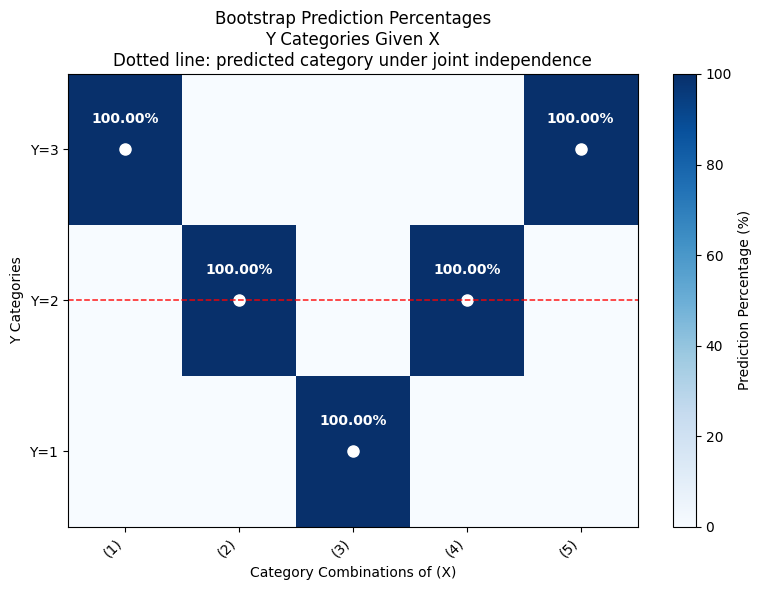

In [11]:
# You can also visualize the results with the attached plotting method
prediction_matrix.plot_prediction_heatmap()

### Permutation Testing for CCRAM & SCCRAM Metrics

We use a permutation test to assess the statistical significance of the observed CCRAM value by comparing it against the permutation null distribution under the null hypothesis of the joint independence between the response variable and the predictors.

Input Arguments:

- `contingency_table`: Multi-dimensional array containing the observed counts
- `predictors`: List of axes representing predictors (1-indexed); can be a single value or multiple axes
- `response`: Axis representing the response variable (1-indexed)
- `alternative`: Direction of the hypothesis test:
    - 'greater': Tests if observed CCRAM is significantly larger than permuted values (right-tailed)
    - 'less': Tests if observed CCRAM is significantly smaller than permuted values (left-tailed)
    - 'two-sided': Tests if observed CCRAM is significantly different from permuted values (two-tailed)
- `n_resamples`: Number of permutation samples to generate (default: 9999)
- `scaled`: Whether to use standard CCRAM (False) or Scaled CCRAM (True) for the test (default: False)
- `random_state`: Seed value for reproducible results (optional)

Output:

Returns a permutation test result object containing the observed value of CCRAM/SCCRAM, the p-value, the permutation estimates of CCRAM/SCCRAM, and methods to visualize the permutation distribution.

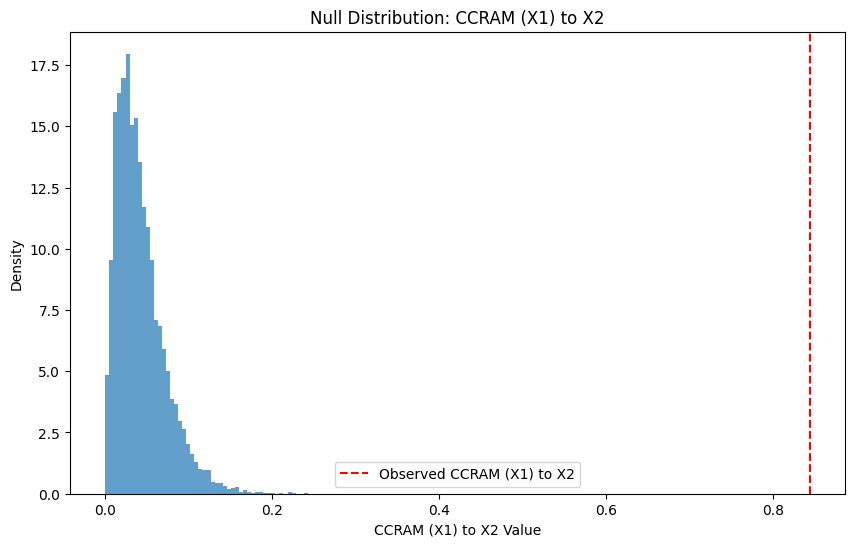

In [12]:
perm_result = permutation_test_ccram(
    contingency_table,
    predictors=[1],
    response=2,
    scaled=False,
    alternative='greater',
    n_resamples=9999
)

In [13]:
print(f"Metric Name: {perm_result.metric_name}")
print(f"Observed Value: {perm_result.observed_value:.4f}")
print(f"P-Value: {perm_result.p_value:.4f}")
print(f"Permutation Distribution (Type): {type(perm_result.null_distribution)}")

# Calculate quantiles
permutation_distribution = perm_result.null_distribution
q01 = np.quantile(permutation_distribution, 0.01)  # 0.01-th quantile
median = np.median(permutation_distribution)       # 0.5-th quantile (median)
q99 = np.quantile(permutation_distribution, 0.99)  # 0.99-th quantile

# Calculate interquartile range (IQR)
q25 = np.quantile(permutation_distribution, 0.25)  # 1st quartile
q75 = np.quantile(permutation_distribution, 0.75)  # 3rd quartile
iqr = q75 - q25

print("\nPermutation Distribution Summary Statistics:")
print(f"0.01-th Quantile: {q01:.4f}")
print(f"0.5-th Quantile (Median): {median:.4f}")
print(f"0.99-th Quantile: {q99:.4f}")
print(f"Interquartile Range (IQR): {iqr:.4f}")

Metric Name: CCRAM (X1) to X2
Observed Value: 0.8438
P-Value: 0.0001
Permutation Distribution (Type): <class 'numpy.ndarray'>

Permutation Distribution Summary Statistics:
0.01-th Quantile: 0.0034
0.5-th Quantile (Median): 0.0366
0.99-th Quantile: 0.1366
Interquartile Range (IQR): 0.0359


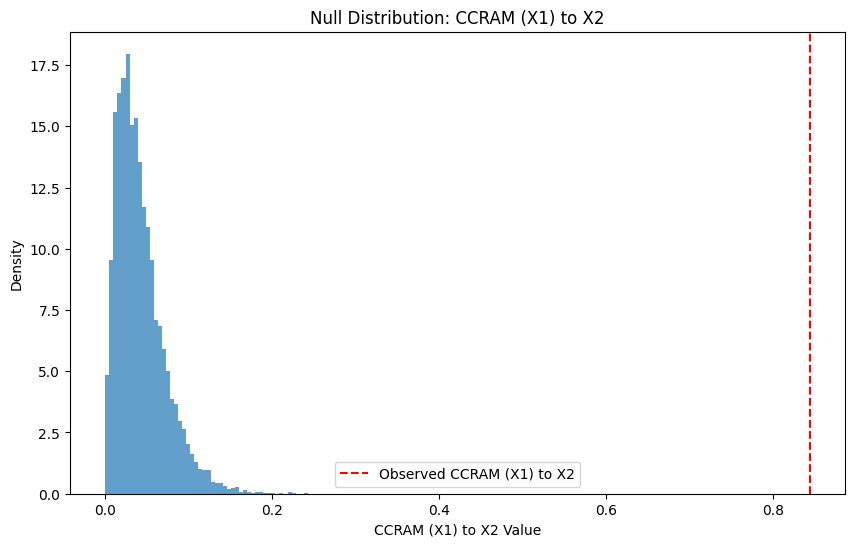

In [14]:
perm_result.histogram_fig

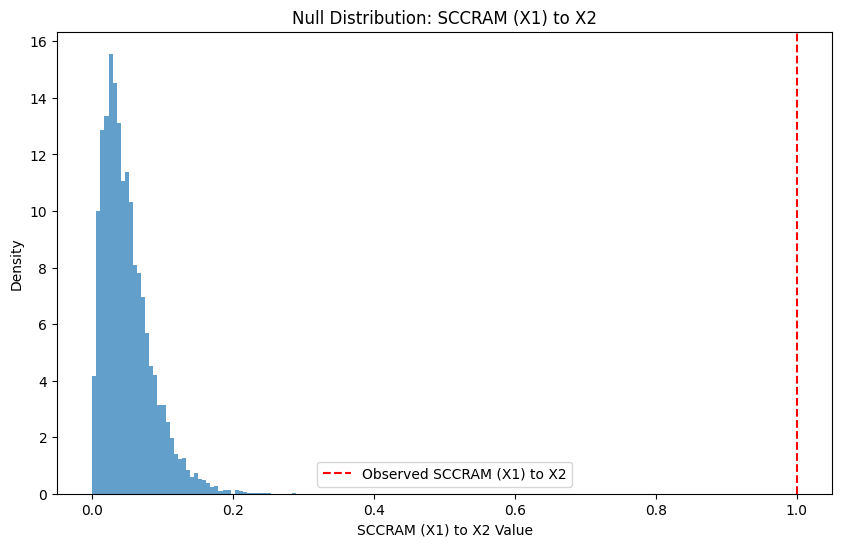

In [15]:
scaled_perm_result = permutation_test_ccram(
    contingency_table,
    predictors=[1],
    response=2,
    scaled=True,
    alternative='greater',
    n_resamples=9999
)

In [16]:
print(f"Metric Name: {scaled_perm_result.metric_name}")
print(f"Observed Value: {scaled_perm_result.observed_value:.4f}")
print(f"P-Value: {scaled_perm_result.p_value:.4f}")
print(f"Permutation Distribution (Type): {type(scaled_perm_result.null_distribution)}")

# Calculate quantiles
scaled_perm_distribution = scaled_perm_result.null_distribution
q01 = np.quantile(scaled_perm_distribution, 0.01)  # 0.01-th quantile
median = np.median(scaled_perm_distribution)       # 0.5-th quantile (median)
q99 = np.quantile(scaled_perm_distribution, 0.99)  # 0.99-th quantile

# Calculate interquartile range (IQR)
q25 = np.quantile(scaled_perm_distribution, 0.25)  # 1st quartile
q75 = np.quantile(scaled_perm_distribution, 0.75)  # 3rd quartile
iqr = q75 - q25

print("\nPermutation Distribution Summary Statistics:")
print(f"0.01-th Quantile: {q01:.4f}")
print(f"0.5-th Quantile (Median): {median:.4f}")
print(f"0.99-th Quantile: {q99:.4f}")
print(f"Interquartile Range (IQR): {iqr:.4f}")

Metric Name: SCCRAM (X1) to X2
Observed Value: 1.0000
P-Value: 0.0001
Permutation Distribution (Type): <class 'numpy.ndarray'>

Permutation Distribution Summary Statistics:
0.01-th Quantile: 0.0037
0.5-th Quantile (Median): 0.0425
0.99-th Quantile: 0.1614
Interquartile Range (IQR): 0.0438


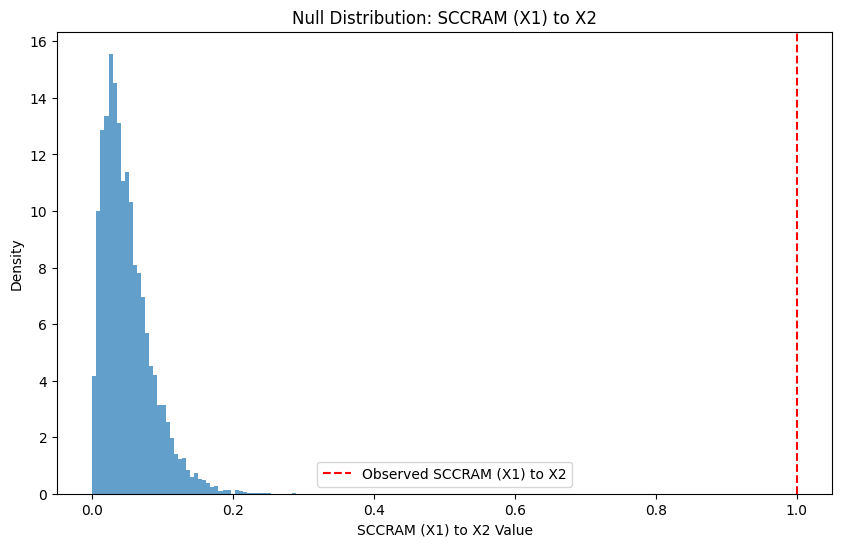

In [17]:
scaled_perm_result.histogram_fig

# 4-Dimensional Case (Real Data Analysis)

### Load Sample Data in Cases / Frequency Form

This example demonstrates how one can analyze relationships between multiple categorical variables in a clinical dataset of back pain treatments using the `DataProcessor`.

The dataset contains 4 categorical variables from a medical study:

| Variable | Description | Categories |
|----------|-------------|------------|
| X₁ | Length of Previous Attack | 1=Short, 2=Long |
| X₂ | Pain Change | 1=Better, 2=Same, 3=Worse |
| X₃ | Lordosis | 1=Absent/Decreasing, 2=Present/Increasing |
| Pain | Back Pain Outcome | worse (W)=1, same (S)=2, slight.improvement (SI)=3, moderate.improvement (MODI)=4, marked.improvement (MARI)=5, complete.relief (CR)=6 |

1. Define variable names, and dimension tuple (the number of categores of each variable according to the order of the variables defined) 
2. (Optional) If your data has any variables with category names that are not integers, then create a category mapping for non-integer categories (for instance, required for 'pain' variable in the above dataset)
3. Load case-form/freq-form data from file (from path provided as an argument) or type table-form with proper mappings into a contingency table

Citation for the above dataset:
- J. A. Anderson, Regression and ordered categorical variables, Journal of the Royal Statistical Society: Series B (Methodological) 46 (1984)
1–22.

In [18]:
var_list_4d = ["x1", "x2", "x3", "pain"]
category_map_4d = {
    "pain": {
        "worse": 1,
        "same": 2,
        "slight.improvement": 3,
        "moderate.improvement": 4,
        "marked.improvement": 5,
        "complete.relief": 6
    },
}
data_dimension = (2, 3, 2, 6)

rda_contingency_table = DataProcessor.load_data(
                        "./data/caseform.pain.txt",
                        data_form="case_form",
                        dimension=data_dimension,
                        var_list=var_list_4d,
                        category_map=category_map_4d,
                        named=True,
                        delimiter="\t"
                    )
print("Read contingency table from case form data!")
print(rda_contingency_table)

rda_contingency_table_from_freq = DataProcessor.load_data(
                        "./data/freqform.pain.txt",
                        data_form="frequency_form",
                        dimension=data_dimension,
                        var_list=var_list_4d,
                        category_map=category_map_4d,
                        named=True,
                        delimiter="\t"
                    )
print("Read contingency table from frequency form data!")
print(rda_contingency_table_from_freq)

Read contingency table from case form data!
[[[[0 1 0 0 2 4]
   [0 0 0 1 3 0]]

  [[0 2 3 0 6 4]
   [0 1 0 2 0 1]]

  [[0 0 0 0 2 2]
   [0 0 1 1 3 0]]]


 [[[0 0 3 0 1 2]
   [0 1 0 0 3 0]]

  [[0 3 4 5 6 2]
   [1 4 4 3 0 1]]

  [[2 2 1 5 2 0]
   [2 0 2 3 0 0]]]]
Read contingency table from frequency form data!
[[[[0 1 0 0 2 4]
   [0 0 0 1 3 0]]

  [[0 2 3 0 6 4]
   [0 1 0 2 0 1]]

  [[0 0 0 0 2 2]
   [0 0 1 1 3 0]]]


 [[[0 0 3 0 1 2]
   [0 1 0 0 3 0]]

  [[0 3 4 5 6 2]
   [1 4 4 3 0 1]]

  [[2 2 1 5 2 0]
   [2 0 2 3 0 0]]]]


### Bootstrap Confidence Interval for CCRAM and SCCRAM

Below, we utilize the bootstrap approach to estimate the variability/uncertainty associated with the estimated CCRAM and SCCRAM.

Before using the bootstrap analysis functions, it's helpful to understand what each input argument does:

- `contingency_table`: Your multi-dimensional array of counts
- `predictors`: Indices of predictors (1-indexed, can be single value or list)
- `response`: Index of the response variable (1-indexed)
- `scaled`: Whether to use standard CCRAM (False) or scaled SCCRAM (True)
- `n_resamples`: Number of bootstrap samples (default is 9999)
- `confidence_level`: Confidence level for interval (default is 0.95 = 95% CI)
- `method`: How to calculate confidence intervals ("percentile", "basic", or "BCa")
- `random_state`: For reproducible results, set a seed value (default is None)

The function returns the observed (S)CCRAM value, confidence intervals, bootstrap estimates of (S)CCRAM as a list of length `n_resamples`, and visualization capabilities.

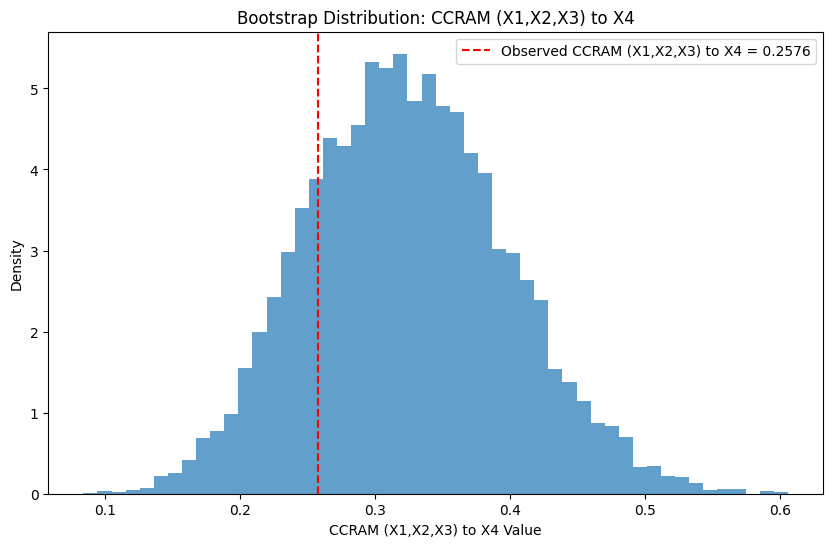

In [19]:
rda_ccram_result = bootstrap_ccram(
    rda_contingency_table,
    predictors=[1, 2, 3],
    response=4,
    confidence_level=0.95,
    scaled=False,
    method="percentile",
    n_resamples=9999
)

In [20]:
print(f"Metric Name: {rda_ccram_result.metric_name}")
print(f"Observed Value: {rda_ccram_result.observed_value:.4f}")
print(f"95% CI: ({rda_ccram_result.confidence_interval[0]:.4f}, {rda_ccram_result.confidence_interval[1]:.4f})")
print(f"Standard Error: {rda_ccram_result.standard_error:.4f}")
print(f"Bootstrap Distribution: {type(rda_ccram_result.bootstrap_distribution)}")

# Retrieve bootstrap estimates
bootstrap_estimates = rda_ccram_result.bootstrap_distribution

# Calculate bootstrap bias
bootstrap_mean = np.mean(bootstrap_estimates)
bootstrap_bias = bootstrap_mean - rda_ccram_result.observed_value

# Calculate bootstrap standard error
bootstrap_std_error = np.std(bootstrap_estimates, ddof=1)

# Calculate ratio of bias to standard error
bias_to_se_ratio = bootstrap_bias / bootstrap_std_error

print("\nAdditional Bootstrap Statistics:")
print(f"Bootstrap Mean: {bootstrap_mean:.4f}")
print(f"Bootstrap Bias: {bootstrap_bias:.4f}")
print(f"Bootstrap Standard Error: {bootstrap_std_error:.4f}")
print(f"Bias to Standard Error Ratio: {bias_to_se_ratio:.4f}")

Metric Name: CCRAM (X1,X2,X3) to X4
Observed Value: 0.2576
95% CI: (0.1868, 0.4780)
Standard Error: 0.0743
Bootstrap Distribution: <class 'numpy.ndarray'>

Additional Bootstrap Statistics:
Bootstrap Mean: 0.3242
Bootstrap Bias: 0.0666
Bootstrap Standard Error: 0.0743
Bias to Standard Error Ratio: 0.8969


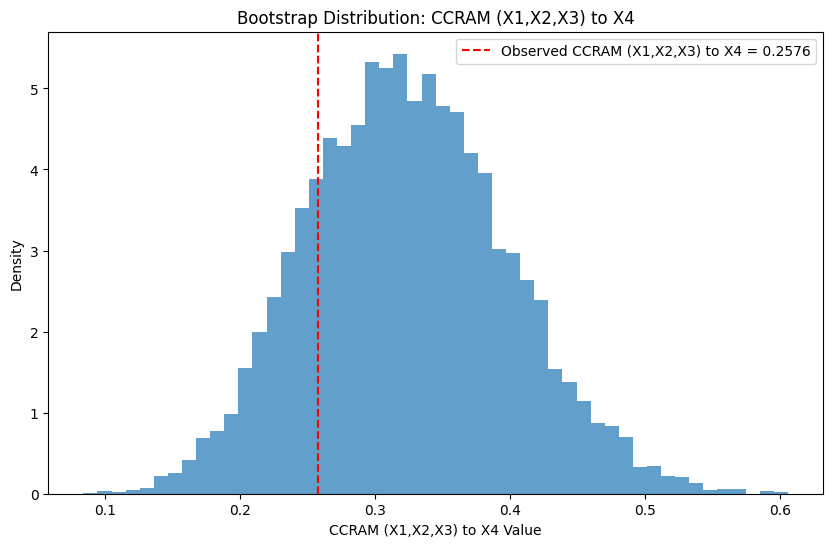

In [21]:
rda_ccram_result.histogram_fig

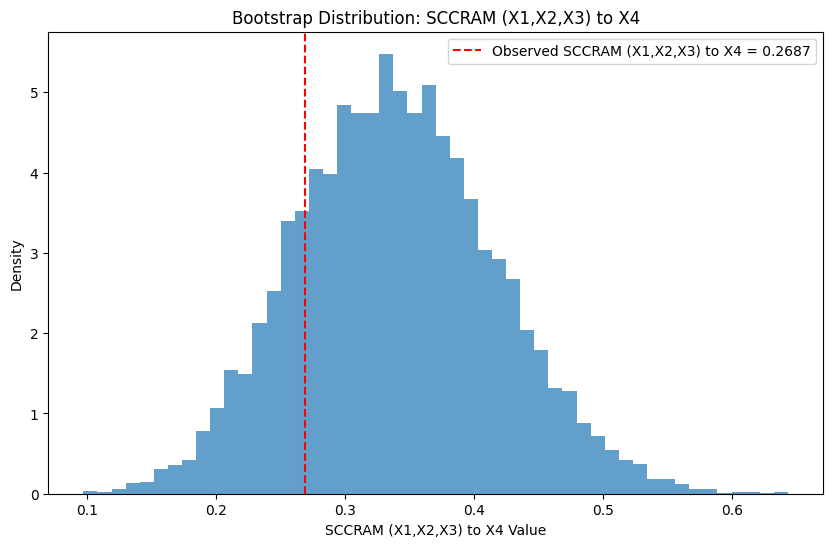

In [22]:
rda_sccram_result = bootstrap_ccram(
    rda_contingency_table,
    predictors=[1, 2, 3],
    response=4,
    confidence_level=0.95,
    scaled=True,
    method="BCa",
    n_resamples=9999
)

In [23]:
print(f"Metric Name: {rda_sccram_result.metric_name}")
print(f"Observed Value: {rda_sccram_result.observed_value:.4f}")
print(f"95% CI: ({rda_sccram_result.confidence_interval[0]:.4f}, {rda_sccram_result.confidence_interval[1]:.4f})")
print(f"Standard Error: {rda_sccram_result.standard_error:.4f}")
print(f"Bootstrap Distribution: {type(rda_sccram_result.bootstrap_distribution)}")

# Retrieve bootstrap estimates
bootstrap_estimates = rda_sccram_result.bootstrap_distribution

# Calculate bootstrap bias
bootstrap_mean = np.mean(bootstrap_estimates)
bootstrap_bias = bootstrap_mean - rda_sccram_result.observed_value

# Calculate bootstrap standard error
bootstrap_std_error = np.std(bootstrap_estimates, ddof=1)

# Calculate ratio of bias to standard error
bias_to_se_ratio = bootstrap_bias / bootstrap_std_error

print("\nAdditional Bootstrap Statistics:")
print(f"Bootstrap Mean: {bootstrap_mean:.4f}")
print(f"Bootstrap Bias: {bootstrap_bias:.4f}")
print(f"Bootstrap Standard Error: {bootstrap_std_error:.4f}")
print(f"Bias to Standard Error Ratio: {bias_to_se_ratio:.4f}")

Metric Name: SCCRAM (X1,X2,X3) to X4
Observed Value: 0.2687
95% CI: (0.0993, 0.3471)
Standard Error: 0.0773
Bootstrap Distribution: <class 'numpy.ndarray'>

Additional Bootstrap Statistics:
Bootstrap Mean: 0.3398
Bootstrap Bias: 0.0711
Bootstrap Standard Error: 0.0773
Bias to Standard Error Ratio: 0.9197


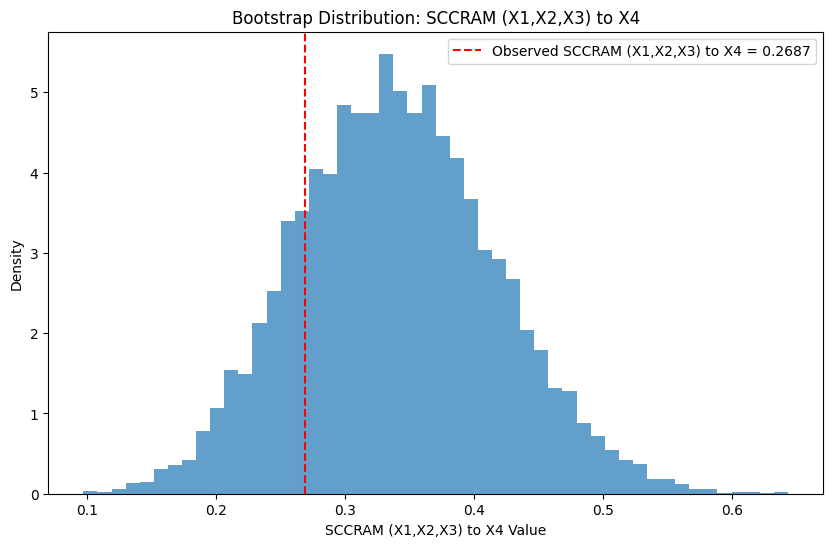

In [24]:
rda_sccram_result.histogram_fig

### Bootstrap Uncertainty Quantification for the Checkerboard Copula Regression (CCR) Prediction

Below, we employ the bootstrap method to estimate the variability/uncertainty associated with the predicted categories of the dependent variable for a combination of categories of the predictors.

Key Features:

- Identifies most likely response categories for each predictor combination
- Provides confidence intervals for prediction probabilities
- Returns organized summary table with prediction statistics

Input Arguments:

- `contingency_table`: Multi-dimensional array of counts
- `predictors`: Indices of predictors in the `contingency_table` (1-indexed)
- `predictors_names`: Names of predictor variables
- `response`: Index of the response variable in the `contingency_table` (1-indexed)
- `response_name` : Name of response variable
- `n_resamples`: Bootstrap sample count (default: 9999)
- `parallel`: Whether to use parallel processing (default=True)

Output:

A DataFrame showing predictor combinations, predicted categories, and the proportion of each category of the response variable estimated by the CCR using the bootstrap resampling.

In [25]:
rda_prediction_matrix = bootstrap_predict_ccr_summary(
    rda_contingency_table,
    predictors=[1, 2, 3],
    predictors_names=["X1", "X2", "X3"],
    response=4,
    response_name="Pain",
    n_resamples=9999,
    parallel=True
)
print("\nPrediction Matrix:")
rda_prediction_matrix

Using 7 cores for parallel processing

Prediction Matrix:


,Pain=1,Pain=2,Pain=3,Pain=4,Pain=5,Pain=6
X1=1 X2=1 X3=1,0.090009,0.140014,0.490049,7.700770,69.826983,21.752175
X1=1 X2=1 X3=2,1.590159,0.000000,0.000000,11.521152,86.888689,0.000000
X1=1 X2=2 X3=1,0.000000,0.000000,0.680068,32.793279,66.426643,0.100010
X1=1 X2=2 X3=2,1.430143,3.460346,16.721672,48.384838,26.822682,3.180318
X1=1 X2=3 X3=1,1.860186,0.000000,0.000000,0.000000,66.086609,32.053205
X1=1 X2=3 X3=2,0.590059,0.000000,2.260226,42.254225,54.895490,0.000000
X1=2 X2=1 X3=1,0.160016,0.000000,7.780778,42.964296,46.214621,2.880288
X1=2 X2=1 X3=2,1.560156,2.810281,6.810681,36.583658,52.235224,0.000000
X1=2 X2=2 X3=1,0.000000,0.000000,3.040304,82.008201,14.951495,0.000000
X1=2 X2=2 X3=2,0.000000,4.370437,77.077708,18.351835,0.200020,0.000000


In [26]:
rda_prediction_matrix.predictions

,Predicted
X1=1 X2=1 X3=1,5
X1=1 X2=1 X3=2,5
X1=1 X2=2 X3=1,5
X1=1 X2=2 X3=2,4
X1=1 X2=3 X3=1,5
X1=1 X2=3 X3=2,5
X1=2 X2=1 X3=1,4
X1=2 X2=1 X3=2,4
X1=2 X2=2 X3=1,4
X1=2 X2=2 X3=2,3


For visualization with `rda_prediction_matrix.plot_prediction_heatmap()`, the three input options are:
1. `show_values`: Boolean specifying if prediction values should be displayed on the heatmap cells (True to show values, False to hide them with default being True)
2. `show_indep_line`: Boolean specifying whether to display a line that separates categories with statistical independence from those with dependencies (True to show the line, False to hide it, default being True)
3. `save_path`: Path to save the output file (ending in ".png" or ".jpg")
3. `figsize`: Tuple specifying figure dimensions as (width, height) in inches (e.g., figsize=(10, 8) creates a figure 10 inches wide and 8 inches tall)

(<Figure size 1440x720 with 2 Axes>,
 <Axes: title={'center': 'Bootstrap Prediction Percentages\nPain Categories Given X1, X2, X3\nDotted line: predicted category under joint independence'}, xlabel='Category Combinations of (X1, X2, X3)', ylabel='Pain Categories'>)

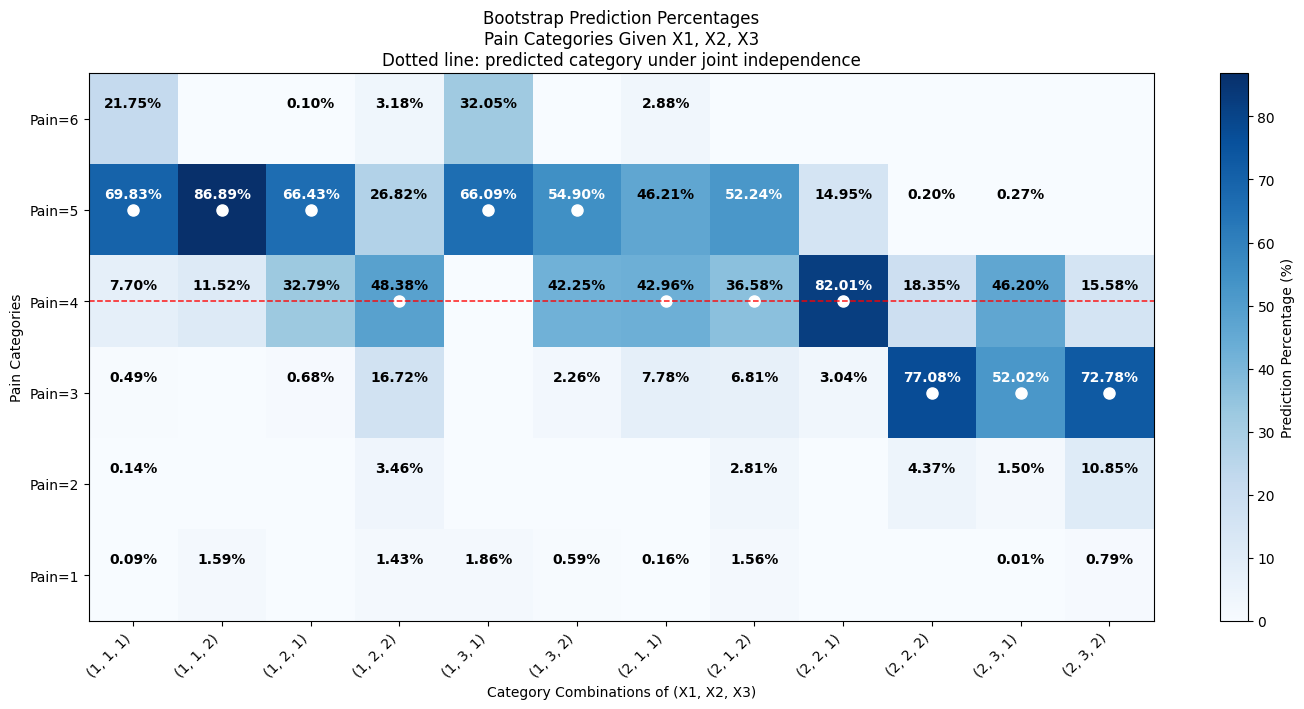

In [27]:
rda_prediction_matrix.plot_prediction_heatmap(save_path="img/4D_prediction_bootstrap_heatmap.png")

(<Figure size 2500x1000 with 2 Axes>,
 <Axes: title={'center': 'Bootstrap Prediction Percentages\nPain Categories Given X1, X2, X3'}, xlabel='Category Combinations of (X1, X2, X3)', ylabel='Pain Categories'>)

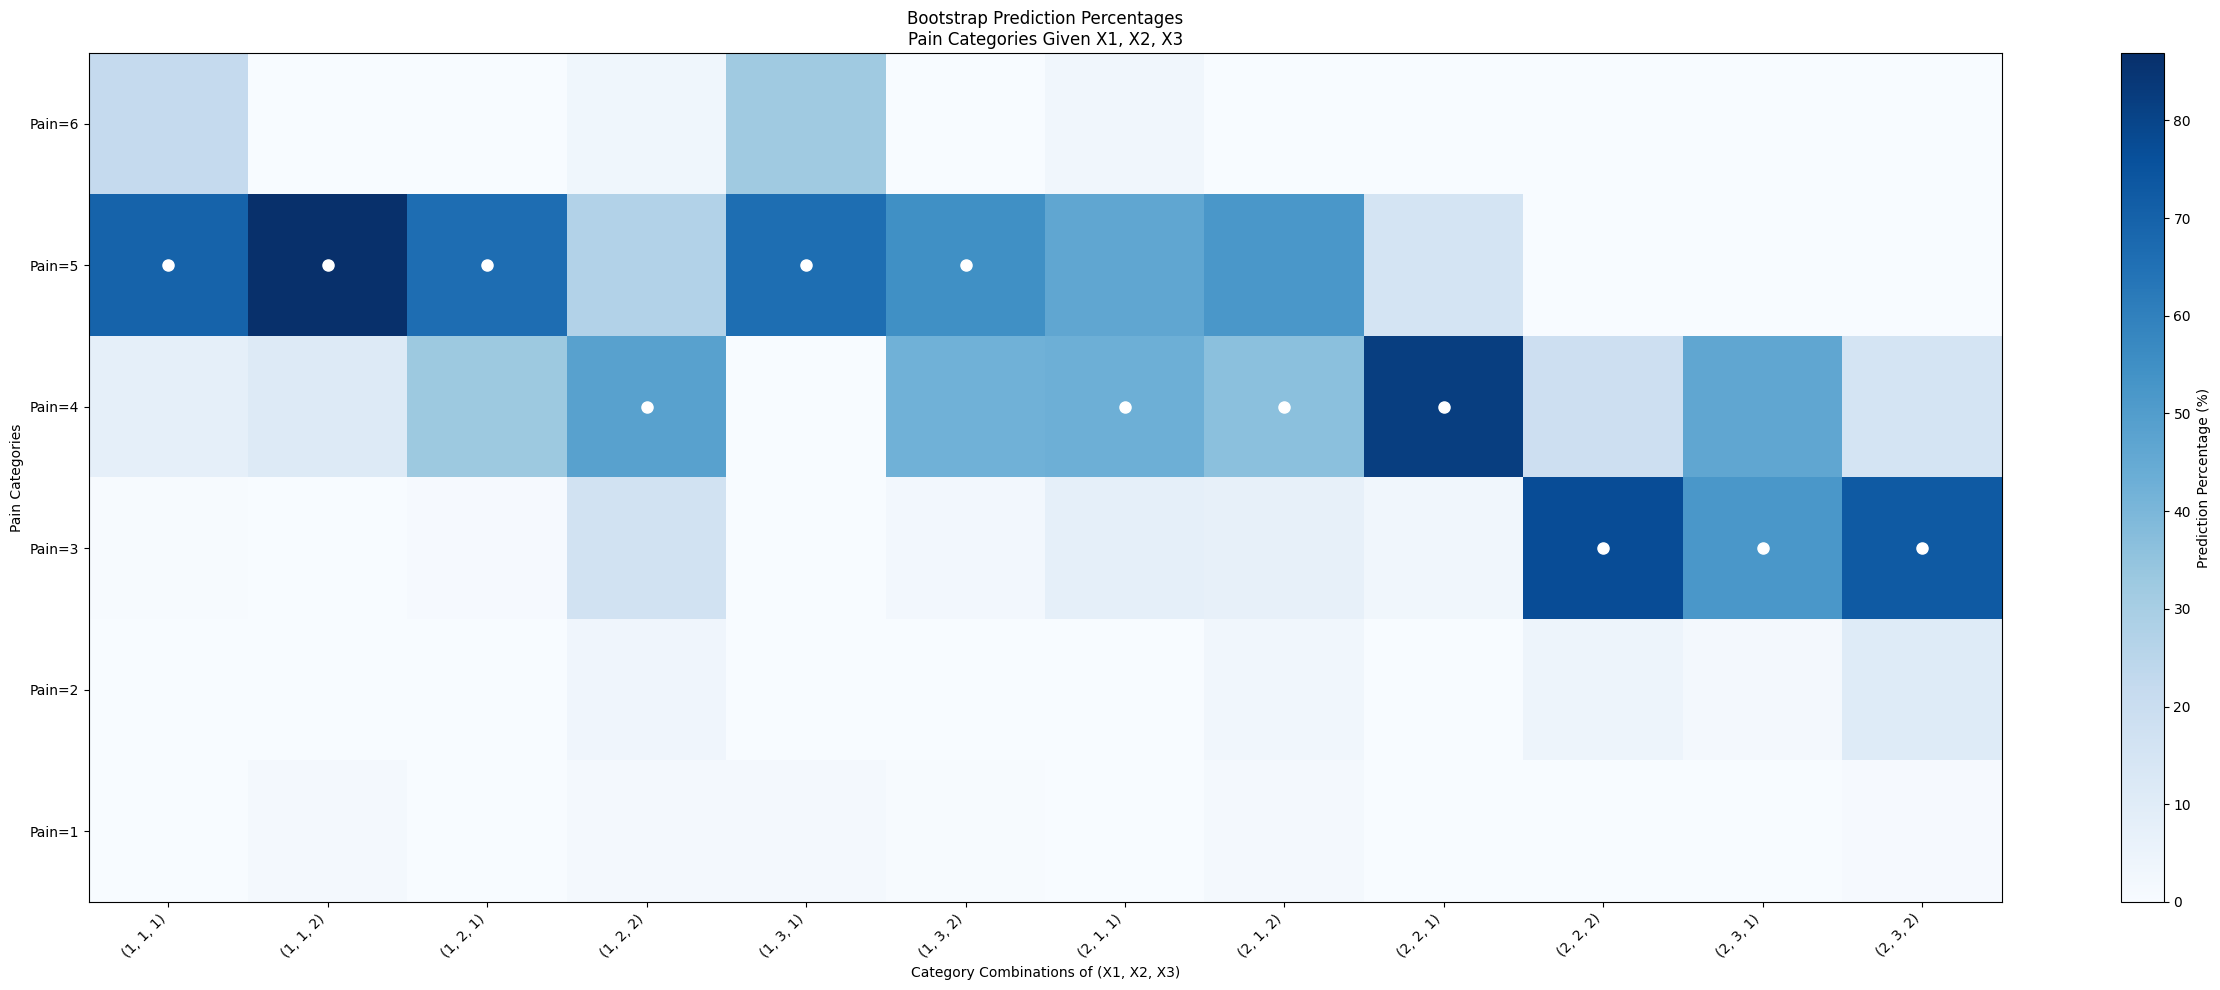

In [28]:
rda_prediction_matrix.plot_prediction_heatmap(show_values=False, show_indep_line=False, figsize=(25, 10))

You can save predictions using the `save_predictions()` function, which allows you to export the prediction matrix to various file formats.

Input Arguments:
- `prediction_matrix`: The prediction matrix object to save
- `save_path`: Path where the file should be saved (including filename and extension)
- `format`: File format to save in (e.g., "csv")

In [29]:
from ccrvam import save_predictions

# Save predictions to a CSV file
save_predictions(
    prediction_matrix=rda_prediction_matrix, 
    save_path="generated_pred_data/rda_prediction_matrix.csv", 
    format="csv",
)

### Permutation Testing for CCRAM & SCCRAM Metrics

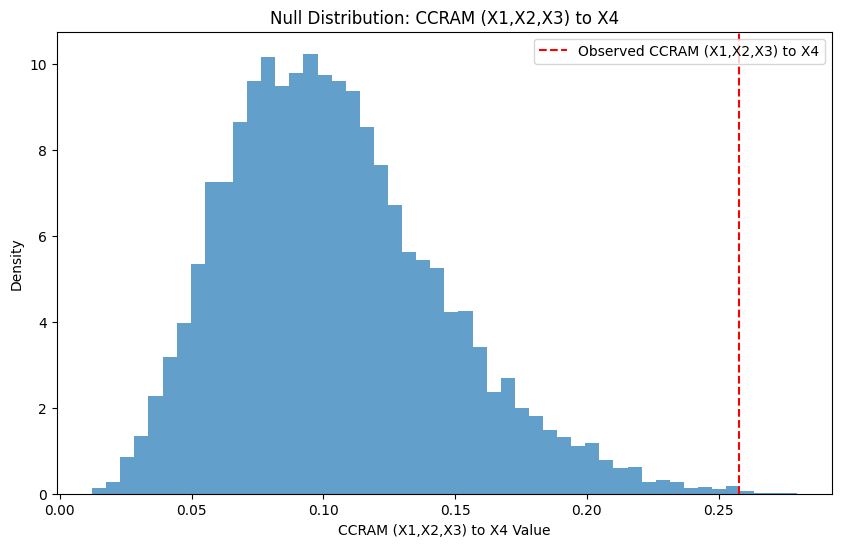

In [30]:
rda_perm_result = permutation_test_ccram(
    rda_contingency_table,
    predictors=[1, 2, 3],
    response=4,
    scaled=False,
    alternative='greater',
    n_resamples=9999
)

In [31]:
print(f"Metric Name: {rda_perm_result.metric_name}")
print(f"Observed Value: {rda_perm_result.observed_value:.4f}")
print(f"P-Value: {rda_perm_result.p_value:.4f}")
print(f"Permutation Distribution (Type): {type(rda_perm_result.null_distribution)}")

# Calculate quantiles
perm_distribution = rda_perm_result.null_distribution
q01 = np.quantile(perm_distribution, 0.01)  # 0.01-th quantile
median = np.median(perm_distribution)       # 0.5-th quantile (median)
q99 = np.quantile(perm_distribution, 0.99)  # 0.99-th quantile

# Calculate interquartile range (IQR)
q25 = np.quantile(perm_distribution, 0.25)  # 1st quartile
q75 = np.quantile(perm_distribution, 0.75)  # 3rd quartile
iqr = q75 - q25

print("\nPermutation Distribution Summary Statistics:")
print(f"0.01-th Quantile: {q01:.4f}")
print(f"0.5-th Quantile (Median): {median:.4f}")
print(f"0.99-th Quantile: {q99:.4f}")
print(f"Interquartile Range (IQR): {iqr:.4f}")

Metric Name: CCRAM (X1,X2,X3) to X4
Observed Value: 0.2576
P-Value: 0.0008
Permutation Distribution (Type): <class 'numpy.ndarray'>

Permutation Distribution Summary Statistics:
0.01-th Quantile: 0.0307
0.5-th Quantile (Median): 0.0999
0.99-th Quantile: 0.2176
Interquartile Range (IQR): 0.0543


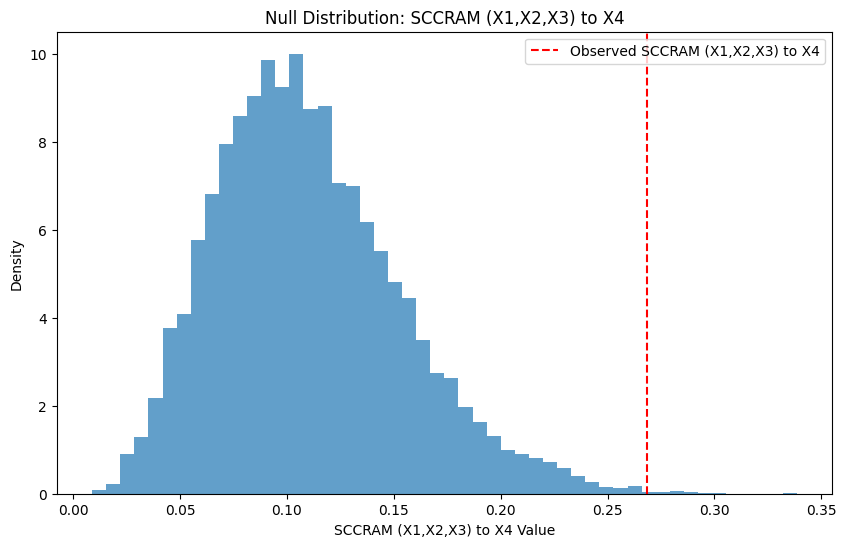

In [32]:
rda_scaled_perm_result = permutation_test_ccram(
    rda_contingency_table,
    predictors=[1, 2, 3],
    response=4,
    scaled=True,
    alternative='greater',
    n_resamples=9999
)

In [33]:
print(f"Metric Name: {rda_scaled_perm_result.metric_name}")
print(f"Observed Value: {rda_scaled_perm_result.observed_value:.4f}")
print(f"P-Value: {rda_scaled_perm_result.p_value:.4f}")
print(f"Permutation Distribution (Type): {type(rda_scaled_perm_result.null_distribution)}")

# Calculate quantiles
scaled_perm_distribution = rda_scaled_perm_result.null_distribution
q01 = np.quantile(scaled_perm_distribution, 0.01)  # 0.01-th quantile
median = np.median(scaled_perm_distribution)       # 0.5-th quantile (median)
q99 = np.quantile(scaled_perm_distribution, 0.99)  # 0.99-th quantile

# Calculate interquartile range (IQR)
q25 = np.quantile(scaled_perm_distribution, 0.25)  # 1st quartile
q75 = np.quantile(scaled_perm_distribution, 0.75)  # 3rd quartile
iqr = q75 - q25

print("\nPermutation Distribution Summary Statistics:")
print(f"0.01-th Quantile: {q01:.4f}")
print(f"0.5-th Quantile (Median): {median:.4f}")
print(f"0.99-th Quantile: {q99:.4f}")
print(f"Interquartile Range (IQR): {iqr:.4f}")

Metric Name: SCCRAM (X1,X2,X3) to X4
Observed Value: 0.2687
P-Value: 0.0016
Permutation Distribution (Type): <class 'numpy.ndarray'>

Permutation Distribution Summary Statistics:
0.01-th Quantile: 0.0306
0.5-th Quantile (Median): 0.1049
0.99-th Quantile: 0.2305
Interquartile Range (IQR): 0.0578
